# This is meant to be run in a jupyter lab IDE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
import os
import numpy as np
import rasterio
from rasterio.transform import from_origin
from sklearn.linear_model import LinearRegression
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_gradient_magnitude
from scipy.signal import convolve, find_peaks

## Reading DTM files

In [ ]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define path
path = r'C:\Users\Utilizador\Documents\DTMs_DGT'

# Get all files in the directory with .xyz extension and sort them
all_files = sorted([f for f in os.listdir(path) if f.endswith('.xyz')])

# Select Files to read
files_to_read = all_files[191:290]

# Container to store each dataset
all_data = []

for file_name in files_to_read:
    file_path = os.path.join(path, file_name)
    # Reading the data with the regex delimiter and ignoring bad lines
    df = pd.read_csv(file_path, sep='\s+', header=None, names=["x", "y", "z"])
    # Replacing -999 values with -5
    df.replace(-999, -40, inplace=True)
    all_data.append(df)

# Combine all datasets into a single DataFrame
combined_df = pd.concat(all_data, ignore_index=True)

# Convert the DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(combined_df.x, combined_df.y)]
combined_gdf = gpd.GeoDataFrame(combined_df, geometry=geometry, crs="EPSG:3763")


In [3]:
combined_gdf

,x,y,z,geometry
0,-49600,177000,2.96,POINT (-49600.000 177000.000)
1,-49598,177000,3.08,POINT (-49598.000 177000.000)
2,-49596,177000,3.20,POINT (-49596.000 177000.000)
3,-49594,177000,3.36,POINT (-49594.000 177000.000)
4,-49592,177000,3.54,POINT (-49592.000 177000.000)
...,...,...,...,...
2006500,-48008,174000,-40.00,POINT (-48008.000 174000.000)
2006501,-48006,174000,-40.00,POINT (-48006.000 174000.000)
2006502,-48004,174000,-40.00,POINT (-48004.000 174000.000)
2006503,-48002,174000,-40.00,POINT (-48002.000 174000.000)


# Geting the coastline

`coastline_gdf`  = dataframe containing x, y, z, and points for coastline detection

In [3]:
# Assuming 'combined_gdf' is already loaded as your GeoDataFrame
# Sort by 'y' first to maintain north-south order, then by 'x' to ensure west-east scanning
combined_gdf.sort_values(by=['y', 'x'], inplace=True)

# Initialize a list to store coastline points
coastline_points = []

# Loop through each unique y-coordinate
for y_val in combined_gdf['y'].unique():
    # Filter data for the current y-coordinate
    temp_df = combined_gdf[combined_gdf['y'] == y_val]
    
    # Find the first transition from negative to non-negative z-value
    transition_found = False
    previous_z = None
    for index, row in temp_df.iterrows():
        if previous_z is not None and previous_z < 2 and row['z'] >= 2:
            coastline_points.append(row)
            transition_found = True
            break
        previous_z = row['z']
    
    # If no transition is found, optionally handle as special case or ignore
    if not transition_found:
        # Implement any specific logic if transition is not found
        continue

# Convert list of points to a GeoDataFrame
coastline_gdf = gpd.GeoDataFrame(coastline_points)



# Geting transects


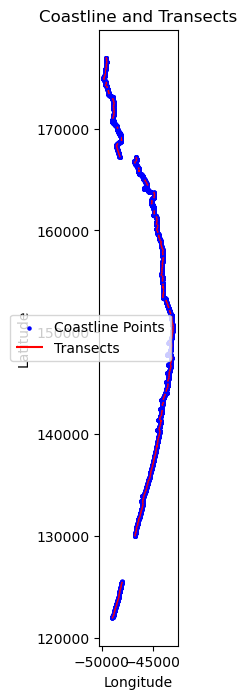

In [4]:
# Assuming `coastline_gdf` is already loaded as your GeoDataFrame
coastline_gdf.sort_values(by='y', inplace=True)

# Initialize a list to store the transects
transects = []

# Iterate through the indices of the sorted GeoDataFrame
for index in range(10, len(coastline_gdf) - 10):  # Ensuring we have both a previous and next item
    point = coastline_gdf.iloc[index]
    north = coastline_gdf.iloc[index - 10]
    south = coastline_gdf.iloc[index + 10]

    # Calculate the vector from north to south
    vector_ns = np.array([south.geometry.x - north.geometry.x, south.geometry.y - north.geometry.y])

    # Calculate a perpendicular vector (rotate 90 degrees to get the perpendicular)
    perp_vector = np.array([-vector_ns[1], vector_ns[0]])

    # Normalize the perpendicular vector
    perp_vector = perp_vector / np.linalg.norm(perp_vector)

    # Calculate the starting and ending points of the transect
    start_point = Point(point.geometry.x + perp_vector[0] * 50, point.geometry.y + perp_vector[1] * 50)  # 50 meters to the west (left)
    end_point = Point(point.geometry.x - perp_vector[0] * 100, point.geometry.y - perp_vector[1] * 100)  # 100 meters to the east (right)

    # Create a LineString for the transect
    transect = LineString([start_point, end_point])
    transects.append({
        'geometry': transect,
        'description': f'Transect at y={point.geometry.y}',
    })

# Convert the list of transects to a GeoDataFrame
transects_gdf = gpd.GeoDataFrame(transects, columns=['geometry', 'description'])

# Select every fifth transect using slicing
transects_gdf_sorted = transects_gdf.iloc[::100].copy()

# Resetting index if needed for clean indexing
transects_gdf_sorted.reset_index(drop=True, inplace=True)

#print(transects_gdf_sorted.geometry)

# Define a function to calculate the angle of the line
def calculate_angle(line):
    # Line should be a shapely LineString object
    if isinstance(line, LineString) and len(line.coords) == 2:
        p1, p2 = line.coords
        angle = np.degrees(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))
        return angle % 360  # Normalize angle to be between 0 and 360 degrees
    return None 

# Apply the function to each transect in the GeoDataFrame
transects_gdf_sorted['angle'] = transects_gdf_sorted['geometry'].apply(calculate_angle)

# Loop through each row in the GeoDataFrame and print the angle
#for index, row in transects_gdf_sorted.iterrows():
    #print(f"Transect at index {index} has an angle of {row['angle']} degrees")

# Filter the DataFrame to keep only transects with angles between 340 to 360 or 0 to 20 degrees
filtered_transects = transects_gdf_sorted[
    (transects_gdf_sorted['angle'] >= 320) | (transects_gdf_sorted['angle'] <= 30)
]

# Reset index of the filtered DataFrame
filtered_transects.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(10, 8))
coastline_gdf.plot(ax=ax, color='blue', markersize=5, label='Coastline Points')
filtered_transects.plot(ax=ax, color='red', label='Transects')
plt.legend()
plt.title('Coastline and Transects')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Functions for geting elevation along transects

In [5]:
def get_elevation_along_line(line, dtm_gdf, tolerance=1):
    """
    Extracts (Point, z-value) from the DTM along a given profile line.
    
    Parameters:
        line (LineString): The transect as a Shapely LineString object.
        dtm_gdf (GeoDataFrame): GeoDataFrame containing the DTM data with 'geometry' and 'z' values.
        tolerance (float): The tolerance within which to consider points as being on the line.
        
    Returns:
        list of tuples: Each tuple contains a Point and its elevation.
    """
    buffered_line = line.buffer(tolerance)
    buffered_gdf = gpd.GeoDataFrame(geometry=[buffered_line], crs=dtm_gdf.crs)
    nearby_points = gpd.sjoin(dtm_gdf, buffered_gdf, predicate='within')
    nearby_points['distance'] = nearby_points['geometry'].apply(lambda point: line.project(point))
    sorted_points = nearby_points.sort_values('distance')

    elevations = [(point.geometry, point['z']) for idx, point in sorted_points.iterrows()]

    return elevations


def plot_elevation_profiles(transects_gdf, dtm_gdf, tolerance=1, num_profiles=5):
    """
    Plots elevation profiles for a given number of transects.
    
    Parameters:
        transects_gdf (GeoDataFrame): GeoDataFrame containing the transects.
        dtm_gdf (GeoDataFrame): GeoDataFrame containing the DTM data.
        tolerance (float): The tolerance within which to consider points as being on the line.
        num_profiles (int): Number of transect profiles to plot.
    """
    fig, axs = plt.subplots(num_profiles, 1, figsize=(10, num_profiles * 3))
    if num_profiles == 1:
        axs = [axs]  # Make it iterable if only one subplot

    # Loop through the first few transects and plot their elevation profiles
    for idx, (index, transect) in enumerate(transects_gdf.iterrows()):
        if idx >= num_profiles:
            break
        transect_line = transect['geometry']
        elevations = get_elevation_along_line(transect_line, dtm_gdf, tolerance)
        distances = [transect_line.project(point) for point, elev in elevations]

        # Plot elevation vs. distance along the transect
        ax = axs[idx] if num_profiles > 1 else axs
        ax.plot(distances, [elev for point, elev in elevations])
        ax.set_title(f'Transect {index} Elevation Profile')
        ax.set_xlabel('Distance along transect (m)')
        ax.set_ylabel('Elevation (m)')

    plt.tight_layout()
    plt.show()

# Assuming 'transects_gdf_sorted' and 'combined_gdf' are properly defined and ready to use
#plot_elevation_profiles(transects_gdf_sorted, combined_gdf, tolerance=1, num_profiles=90)

## Trying the function for interactive plot

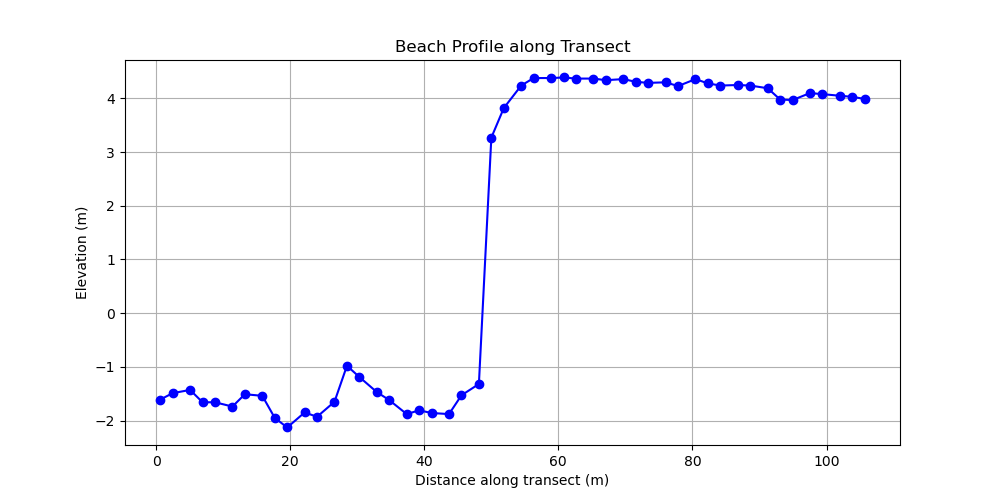

In [7]:
%matplotlib widget
import matplotlib.pyplot as plt

transect_line = filtered_transects.iloc[0]['geometry']  # Adjust the index if you want a different transect
transect_line


combined_gdf['geometry'] = combined_gdf.apply(lambda row: Point(row['x'], row['y']), axis=1)
combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry='geometry')
combined_gdf.crs = {'init': 'epsg:3763'}  # Ensure the CRS matches your project needs

elevations_along_transect = get_elevation_along_line(transect_line, combined_gdf, tolerance=1)


# Assuming elevations_along_transect contains tuples of (Point, elevation)
distances = [transect_line.project(point) for point, elevation in elevations_along_transect]
elevations = [elevation for point, elevation in elevations_along_transect]

plt.figure(figsize=(10, 5))
plt.plot(distances, elevations, marker='o', linestyle='-', color='b')
plt.title('Beach Profile along Transect')
plt.xlabel('Distance along transect (m)')
plt.ylabel('Elevation (m)')
plt.grid(True)

plt.ion()
plt.show()

## Interactive plot for obtaining dune toe and crest

In [8]:
# Initialize DataFrames to store z0, ztoe, and zct (dune crest)
df_z0 = pd.DataFrame(columns=['x', 'y', 'elevation'])
df_ztoe = pd.DataFrame(columns=['x', 'y', 'elevation'])
df_zct = pd.DataFrame(columns=['x', 'y', 'elevation'])  # DataFrame for dune crest

In [9]:
def plot_transect(transect, dtm_gdf, index):
    # Get elevations along the transect
    elevations_along_transect = get_elevation_along_line(transect.geometry, dtm_gdf, tolerance=1)
    distances = [transect.geometry.project(point) for point, elevation in elevations_along_transect]
    elevations = [elevation for point, elevation in elevations_along_transect]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.plot(distances, elevations, marker='o', linestyle='-')
    ax.set_title(f'Transect {index} Elevation Profile')
    ax.set_xlabel('Distance along transect (m)')
    ax.set_ylim(-4, 16)
    ax.set_ylabel('Elevation (m)')
    ax.grid(True)
    points_clicked = []

    # Function to handle clicks
    def onclick(event):
        if event.inaxes != ax:
            return
        ix, iy = event.xdata, event.ydata
        points_clicked.append((ix, iy))
        
        if len(points_clicked) == 1:
            ax.plot(ix, iy, 'ro')  # red point for z0
            print(f'z0 marked at ({ix}, {iy})')
        elif len(points_clicked) == 2:
            ax.plot(ix, iy, 'bo')  # blue point for ztoe
            print(f'ztoe marked at ({ix}, {iy})')
        elif len(points_clicked) == 3:
            ax.plot(ix, iy, 'go')  # green point for zct (dune crest)
            print(f'zct marked at ({ix}, {iy})')

            # Update DataFrames
            df_z0.loc[index] = {
                'x': transect.geometry.interpolate(points_clicked[0][0]).x,
                'y': transect.geometry.interpolate(points_clicked[0][0]).y,
                'elevation': points_clicked[0][1]
            }
            df_ztoe.loc[index] = {
                'x': transect.geometry.interpolate(points_clicked[1][0]).x,
                'y': transect.geometry.interpolate(points_clicked[1][0]).y,
                'elevation': points_clicked[1][1]
            }
            df_zct.loc[index] = {
                'x': transect.geometry.interpolate(points_clicked[2][0]).x,
                'y': transect.geometry.interpolate(points_clicked[2][0]).y,
                'elevation': points_clicked[2][1]
            }
            
            plt.close(fig)  # Close the plot automatically after the third click

    # Connect the click event to the onclick function
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

    plt.show()

# Use this function to process your transects.


In [6]:
filtered_transects

,geometry,description,angle
0,"LINESTRING (-49014.424 122038.570, -48875.152 ...",Transect at y=122020.0,338.198591
1,"LINESTRING (-48916.875 122245.725, -48788.251 ...",Transect at y=122220.0,329.036243
2,"LINESTRING (-48871.029 122429.806, -48723.942 ...",Transect at y=122420.0,348.690068
3,"LINESTRING (-48817.447 122627.417, -48669.106 ...",Transect at y=122620.0,351.469234
4,"LINESTRING (-48771.891 122834.367, -48628.217 ...",Transect at y=122820.0,343.300756
...,...,...,...
209,"LINESTRING (-49635.938 176092.497, -49486.125 ...",Transect at y=176090.0,357.137595
210,"LINESTRING (-49631.938 176292.497, -49482.125 ...",Transect at y=176290.0,357.137595
211,"LINESTRING (-49597.938 176492.497, -49448.125 ...",Transect at y=176490.0,357.137595
212,"LINESTRING (-49605.938 176687.503, -49456.125 ...",Transect at y=176690.0,2.862405


## HERE WE HAVE TO IMPROVE, 
now we have to manually change the filtered_transects[___] until it fits all, because if we plot all at once it crashes.


In [21]:
df_z0

,x,y,elevation
1,-48898.742964,122234.845778,0.529225
2,-48841.832184,122423.966437,1.357147
3,-48779.833604,122621.775041,1.220059
4,-48751.120305,122828.136092,0.650078
5,-48673.527569,123027.811028,0.715013
...,...,...,...
209,-49573.936374,176089.396819,4.950219
210,-49591.095411,176290.454771,1.133485
211,-49571.519621,176491.175981,-0.850641
212,-49575.641797,176689.017910,-0.367243


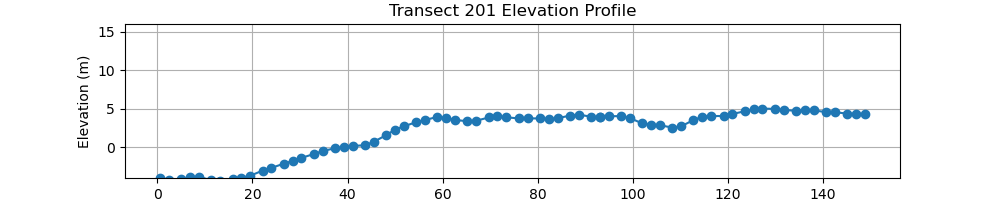

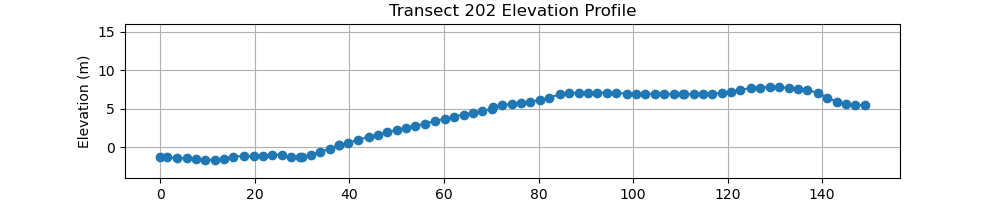

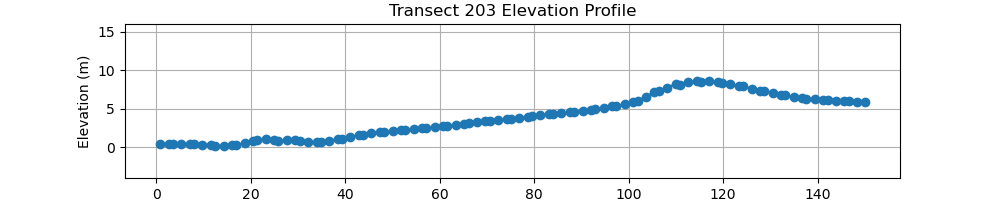

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_27020\4228136673.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 2))


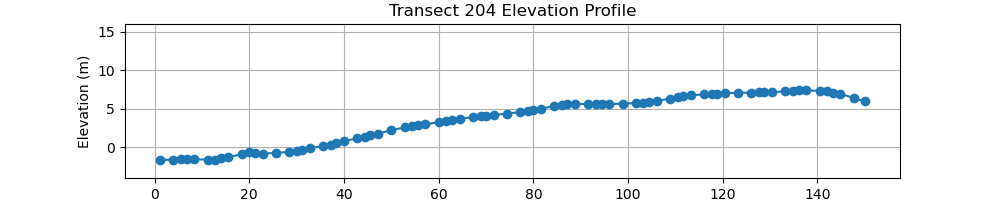

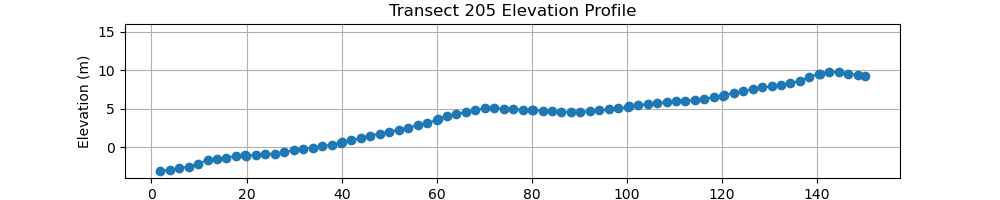

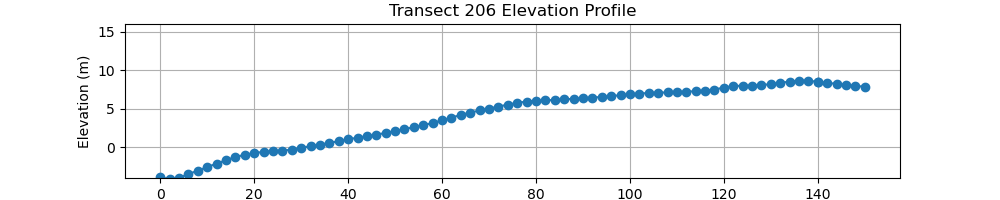

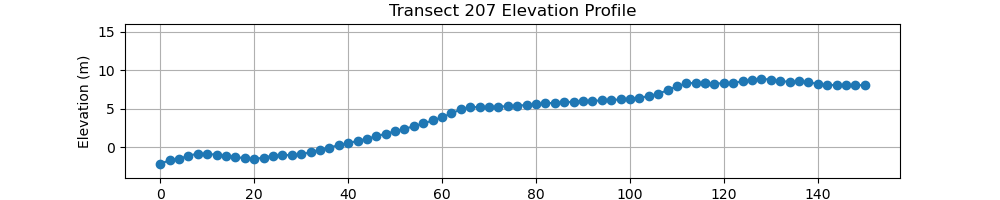

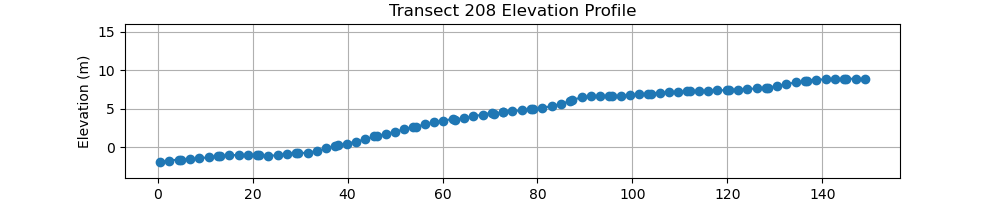

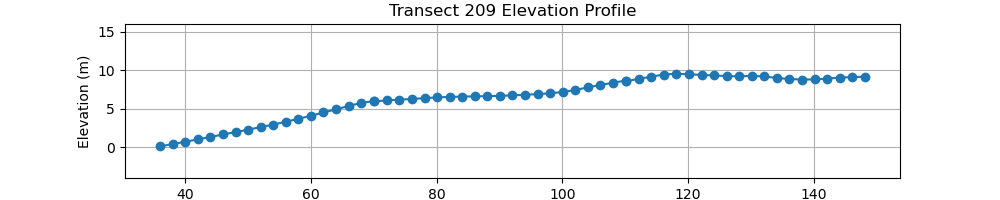

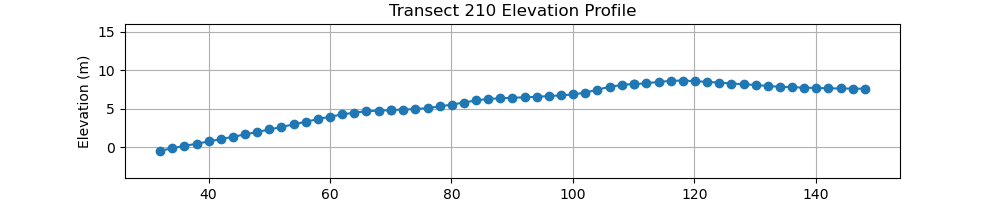

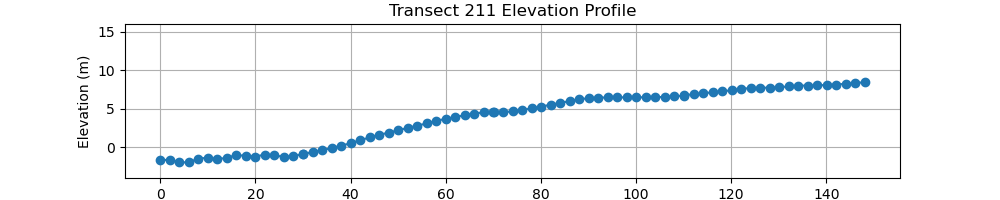

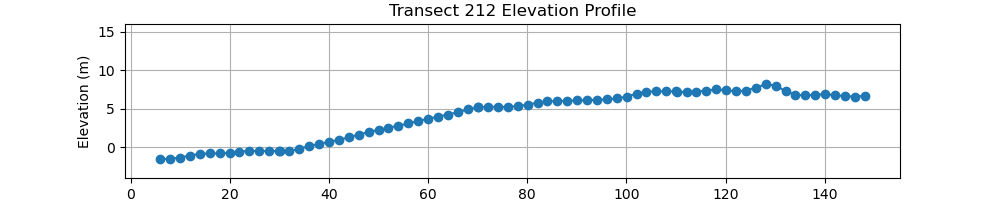

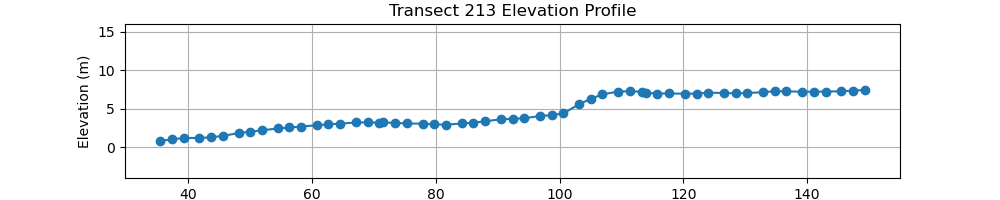

In [20]:
# Assuming a function that sequentially calls the next plot
def plot_all_transects(filtered_transects, combined_gdf):
    for i, transect in filtered_transects.iterrows():
        plot_transect(transect, combined_gdf, i)

# Call this in an interactive environment
plot_all_transects(filtered_transects[201:], combined_gdf)

 # saving dfzs into a new dataframe df_slope

In [22]:
# Calculate the distance from the transect start to the point for df_z0 and df_ztoe
df_z0['distance'] = [filtered_transects.iloc[index].geometry.project(Point(row['x'], row['y'])) for index, row in df_z0.iterrows()]
df_ztoe['distance'] = [filtered_transects.iloc[index].geometry.project(Point(row['x'], row['y'])) for index, row in df_ztoe.iterrows()]
#df_zct['distance'] = [filtered_transects.iloc[index].geometry.project(Point(row['x'], row['y'])) for index, row in df_zct.iterrows()]

# Calculate the slope for each transect
df_slope = pd.DataFrame({
    'x0': df_z0['x'],
    'y0': df_z0['y'],
    'elevation0': df_z0['elevation'],
    'xtoe': df_ztoe['x'],
    'ytoe': df_ztoe['y'],
    'elevationtoe': df_ztoe['elevation'],
    'slope': (df_ztoe['elevation'] - df_z0['elevation']) / (df_ztoe['distance'] - df_z0['distance'])
})

# Merge df_slope with df_zct
df_slope = pd.merge(df_slope, df_zct, how='left', left_index=True, right_index=True, suffixes=('', 'ct'))

# Rename the columns from df_zct to match the requirement
df_slope.rename(columns={
    'x': 'xct',
    'y': 'yct',
    'elevation': 'elevationct'
}, inplace=True)

# Optionally, print or inspect the slope dataframe
print(df_slope)

#df_slope['slope'].mean()

#df_slope.to_csv('beach_slope_191to290_data.csv', index=False)


               x0             y0  elevation0          xtoe           ytoe  \
1   -48898.742964  122234.845778    0.529225 -48828.559469  122192.735681   
2   -48841.832184  122423.966437    1.357147 -48741.414396  122403.882879   
3   -48779.833604  122621.775041    1.220059 -48698.271499  122609.540725   
4   -48751.120305  122828.136092    0.650078 -48673.835262  122804.950579   
5   -48673.527569  123027.811028    0.715013 -48613.770772  123003.908309   
..            ...            ...         ...           ...            ...   
209 -49573.936374  176089.396819    4.950219 -49533.746192  176087.387310   
210 -49591.095411  176290.454771    1.133485 -49532.362578  176287.518129   
211 -49571.519621  176491.175981   -0.850641 -49516.942433  176488.447122   
212 -49575.641797  176689.017910   -0.367243 -49507.544762  176692.422762   
213 -49598.369416  176885.670704    0.895384 -49538.591881  176906.592842   

     elevationtoe     slope           xct            yct  elevationct  
1  

# saving transect coordinates for the future post-processing

In [23]:
from shapely.ops import transform
import pyproj

def extract_coordinates(df, init_crs, target_crs):
    transformer = pyproj.Transformer.from_crs(init_crs, target_crs, always_xy=True)

    def get_coords(row):
        coords = list(row.geometry.coords)
        start = transform(transformer.transform, Point(coords[0]))
        end = transform(transformer.transform, Point(coords[-1]))
        return pd.Series([start.x, start.y, end.x, end.y], index=['start_x', 'start_y', 'end_x', 'end_y'])

    coord_df = df.apply(get_coords, axis=1)
    return coord_df

# Define CRS
init_crs = 'epsg:3763'  # Replace with your current CRS
target_crs = 'epsg:4326'  # WGS 84

# Extract and convert coordinates
transect_coords = extract_coordinates(filtered_transects, init_crs, target_crs)
#transect_coords
transect_coords.to_csv('transects_x_y_191_to_290.csv', index=False)

# Now our most important task was made, which was finding dune toes and crest along all the DTM, as well as slope.

In [91]:
df_slope = pd.read_csv(r"C:\Users\Utilizador\Documents\Projects\Systematical Approach\mid_tier_approach\191_to_290\beach_slope_191to290_data.csv")
transect_coords = pd.read_csv(r"C:\Users\Utilizador\Documents\Projects\Systematical Approach\mid_tier_approach\191_to_290\transects_x_y_191_to_290.csv")


In [ ]:
# Assume df_slope and filtered_transects are already defined and loaded as GeoDataFrame and DataFrame respectively

# Extracting y-coordinates from the start or representative point of each transect
filtered_transects['y_coord'] = filtered_transects['geometry'].apply(lambda x: x.coords[0][1])

# Extract y0 from df_slope
df_slope['y_coord'] = df_slope['y0']

# You may need a tolerance for matching due to floating point precision issues
tolerance = 150  # Adjust this based on the precision and scale of your coordinate system

# Finding matches: for each transect, check if there's a close y0 in df_slope
matched_indices = []
for index, transect in filtered_transects.iterrows():
    close_entries = df_slope[(df_slope['y_coord'] >= transect['y_coord'] - tolerance) & 
                             (df_slope['y_coord'] <= transect['y_coord'] + tolerance)]
    if not close_entries.empty:
        matched_indices.append(index)

# Filtered GeoDataFrame based on matched indices
new_filtered_transects = filtered_transects.loc[matched_indices].copy()

# Output some diagnostics
print("Original number of transects:", len(filtered_transects))
print("Number of matched transects:", len(new_filtered_transects))

# Optionally drop the auxiliary 'y_coord' column if no longer needed
filtered_transects.drop(columns=['y_coord'], inplace=True)
df_slope.drop(columns=['y_coord'], inplace=True)

# Display or return new_filtered_transects as needed
print(new_filtered_transects)


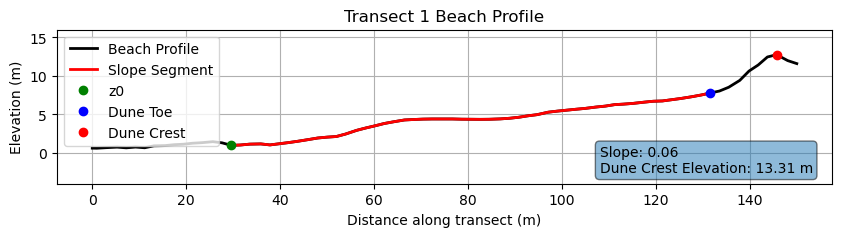

<Figure size 640x480 with 0 Axes>

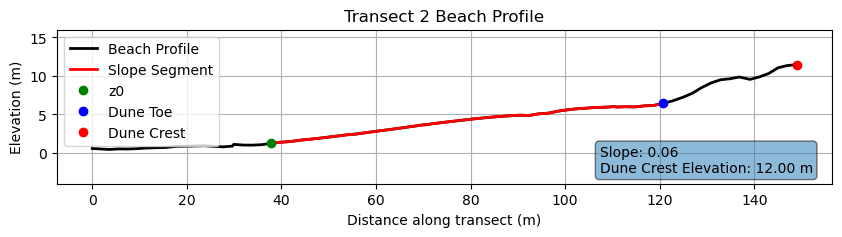

<Figure size 640x480 with 0 Axes>

In [101]:


def plot_and_save_transects(filtered_transects, dtm_gdf, df_slope, start_index, end_index, directory):
    for i in range(start_index, end_index):
        transect = filtered_transects.iloc[i]
        filename = f'transect_profile_{i}.png'
        save_path = os.path.join(directory, filename)  # Create full path for saving
        plot_beach_profile(transect, dtm_gdf, i, df_slope, save_path)


def plot_beach_profile(transect, dtm_gdf, index, df_slope, save_path):
    # Extract elevations along the transect
    elevations_along_transect = get_elevation_along_line(transect.geometry, dtm_gdf, tolerance=1)
    distances = [transect.geometry.project(point) for point, elevation in elevations_along_transect]
    elevations = [elevation for point, elevation in elevations_along_transect]

    # Fetch slope details for this transect
    slope_details = df_slope.iloc[index]  # Fetching specific transect details based on index

    # Find the distances along the transect closest to x0, xtoe, and xct
    z0_distance = min(distances, key=lambda d: abs(transect.geometry.interpolate(d).x - slope_details['x0']))
    ztoe_distance = min(distances, key=lambda d: abs(transect.geometry.interpolate(d).x - slope_details['xtoe']))
    zct_distance = min(distances, key=lambda d: abs(transect.geometry.interpolate(d).x - slope_details['xct']))

    # Find indices for z0, ztoe, and zct
    z0_idx = distances.index(z0_distance)
    ztoe_idx = distances.index(ztoe_distance)
    zct_idx = distances.index(zct_distance)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 2))
    profile_line, = ax.plot(distances, elevations, 'k-', label='Beach Profile', linewidth=2)
    slope_segment, = ax.plot(distances[z0_idx:ztoe_idx+1], elevations[z0_idx:ztoe_idx+1], 'r-', label='Slope Segment', linewidth=2)

    # Mark z0, ztoe, and zct
    z0_marker, = ax.plot(z0_distance, elevations[z0_idx], 'go', label='z0')
    ztoe_marker, = ax.plot(ztoe_distance, elevations[ztoe_idx], 'bo', label='Dune Toe')
    zct_marker, = ax.plot(zct_distance, elevations[zct_idx], 'ro', label='Dune Crest')

    # Adding legend
    ax.legend(handles=[profile_line, slope_segment, z0_marker, ztoe_marker, zct_marker], loc = 'upper left')

    # Display additional information
    slope_info = f"Slope: {slope_details['slope']:.2f}"
    elevation_info = f"Dune Crest Elevation: {slope_details['elevationct']:.2f} m"
    ax.text(0.70, 0.25, f'{slope_info}\n{elevation_info}', transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

    ax.set_title(f'Transect {index} Beach Profile')
    ax.set_xlabel('Distance along transect (m)')
    ax.set_ylabel('Elevation (m)')
    ax.set_ylim(-4, 16)
    ax.grid(True)
    plt.show()
    
    plt.savefig(save_path, transparent=True, bbox_inches='tight')  # Save the figure with a transparent background
    plt.close(fig)  # Close the plot to free memory

# Directory setup and example usage
directory = r"C:\Users\Utilizador\Documents\Projects\Systematical Approach\mid_tier_approach\191_to_290"
if not os.path.exists(directory):
    os.makedirs(directory)  # Ensure directory exists

# Call the function as needed
plot_and_save_transects(new_filtered_transects, combined_gdf, df_slope, 1, 3, directory)

In [106]:


def plot_and_save_transects(filtered_transects, dtm_gdf, df_slope, start_index, end_index, directory):
    for i in range(start_index, end_index):
        transect = new_filtered_transects.iloc[i]
        filename = f'transect_profile_{i}.png'
        save_path = os.path.join(directory, filename)  # Create full path for saving
        plot_beach_profile(transect, dtm_gdf, i, df_slope, save_path)


def plot_beach_profile(transect, dtm_gdf, index, df_slope, save_path):
    # Extract elevations along the transect
    elevations_along_transect = get_elevation_along_line(transect.geometry, dtm_gdf, tolerance=1)
    distances = [transect.geometry.project(point) for point, elevation in elevations_along_transect]
    elevations = [elevation for point, elevation in elevations_along_transect]

    # Fetch slope details for this transect
    slope_details = df_slope.iloc[index]  # Fetching specific transect details based on index

    # Find the distances along the transect closest to x0, xtoe, and xct
    z0_distance = min(distances, key=lambda d: abs(transect.geometry.interpolate(d).x - slope_details['x0']))
    ztoe_distance = min(distances, key=lambda d: abs(transect.geometry.interpolate(d).x - slope_details['xtoe']))
    zct_distance = min(distances, key=lambda d: abs(transect.geometry.interpolate(d).x - slope_details['xct']))

    # Find indices for z0, ztoe, and zct
    z0_idx = distances.index(z0_distance)
    ztoe_idx = distances.index(ztoe_distance)
    zct_idx = distances.index(zct_distance)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 2))
    profile_line, = ax.plot(distances, elevations, 'k-', label='Beach Profile', linewidth=2)
    slope_segment, = ax.plot(distances[z0_idx:ztoe_idx+1], elevations[z0_idx:ztoe_idx+1], 'r-', label='Slope Segment', linewidth=2)

    # Mark z0, ztoe, and zct
    z0_marker, = ax.plot(z0_distance, elevations[z0_idx], 'go', label='z0')
    ztoe_marker, = ax.plot(ztoe_distance, elevations[ztoe_idx], 'bo', label='Dune Toe')
    zct_marker, = ax.plot(zct_distance, elevations[zct_idx], 'ro', label='Dune Crest')

    # Adding legend
    ax.legend(handles=[profile_line, slope_segment, z0_marker, ztoe_marker, zct_marker], loc = 'upper left')

    # Display additional information
    slope_info = f"Slope: {slope_details['slope']:.2f}"
    elevation_info = f"Dune Crest Elevation: {slope_details['elevationct']:.2f} m"
    ax.text(0.70, 0.25, f'{slope_info}\n{elevation_info}', transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

    ax.set_title(f'Transect {index} Beach Profile')
    ax.set_xlabel('Distance along transect (m)')
    ax.set_ylabel('Elevation (m)')
    ax.set_ylim(-4, 16)
    ax.grid(True)
    #plt.show()
    
    plt.savefig(save_path, transparent=False, bbox_inches='tight')  # Save the figure with a transparent background
    plt.close(fig)  # Close the plot to free memory

# Directory setup and example usage
directory = r"C:\Users\Utilizador\Documents\Projects\Systematical Approach\mid_tier_approach\191_to_290\profiles"
if not os.path.exists(directory):
    os.makedirs(directory)  # Ensure directory exists

# Call the function as needed
plot_and_save_transects(new_filtered_transects, combined_gdf, df_slope, 1, len(new_filtered_transects), directory)